In [12]:
import matplotlib.pyplot as plt
import simpreglib as srl
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats

plt.style.use('fivethirtyeight')

In [41]:
df1=pd.read_csv('data/cleaned_kc.csv')
df2=pd.read_csv('data/kc_house_data.csv')
dfo = df2[['price','grade','sqft_living','sqft_lot','bedrooms','bathrooms']]
df1.drop('waterfront_loc',axis=1,inplace=True)

In [43]:
# df1.head()

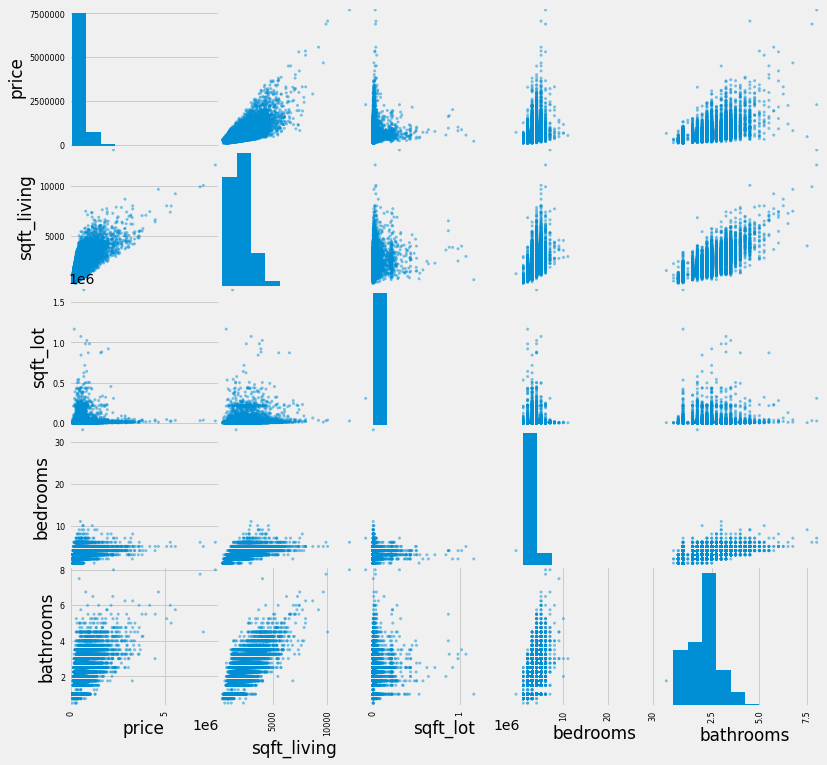

In [31]:
pd.plotting.scatter_matrix(dfo,figsize=(12,12))
plt.show()

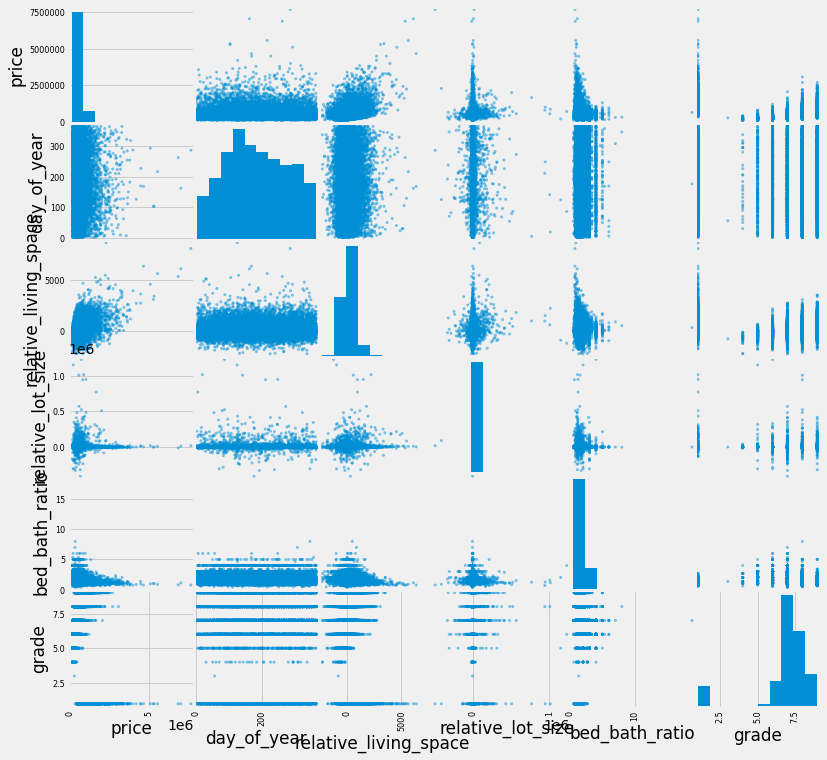

In [32]:
pd.plotting.scatter_matrix(df1,figsize=(12,12))
plt.show()

#### Simple linear regression on select features
Assumtion check: 
- is it linear?
- is it normal?
    - histogram
    - Q-Q plot
- is it homoscedastic?

##### For engineered features . . .

In [66]:
df1.columns

Index(['price', 'day_of_year', 'relative_living_space', 'relative_lot_size',
       'bed_bath_ratio', 'grade'],
      dtype='object')

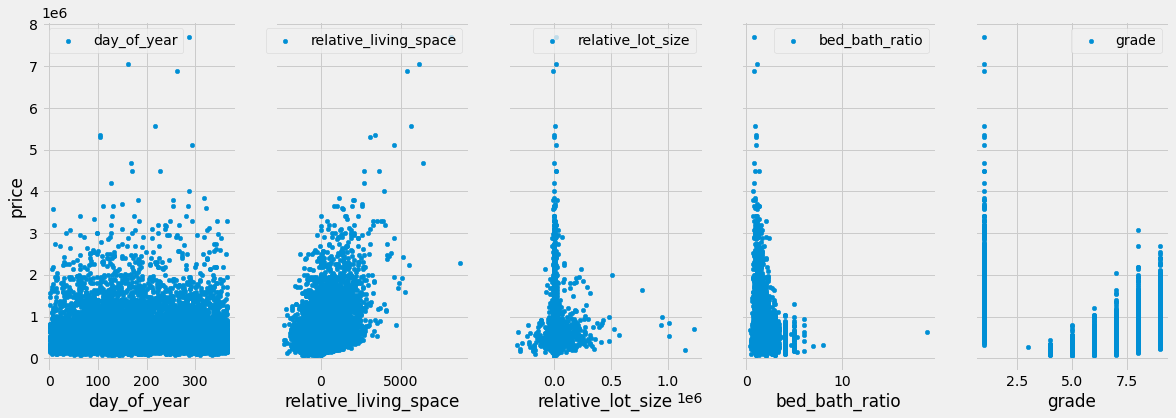

In [69]:
# visualize the relationship between the predictors and the target using scatterplots
fig, axs = plt.subplots(1, 5,sharey=True, figsize=(18, 6))
labels = df1.columns[1:]
for idx, channel in enumerate(labels):
    df1.plot(kind='scatter', x=channel, y='price', ax=axs[idx], label=channel)
    
plt.legend()
plt.show()

In [73]:
# # For all the variables, check distribution by creating a histogram with kde
# for column in df1 :
#     df1[column].plot.hist(density=True,label = column+' histogram')
#     df1[column].plot.kde(label = column+' kde')
#     plt.legend()
#     plt.show()

The plots above show relative living space, and grade to be the most promising

In [51]:

fspace = 'price~relative_living_space'
fgrade = 'price~grade'
space_model = smf.ols(formula=fspace, data=df1).fit()
grade_model = smf.ols(formula=fgrade, data=df1).fit()

In [52]:
print(space_model.pvalues)
space_model.summary()

Intercept                0.0
relative_living_space    0.0
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     4244.
Date:                Sun, 06 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:30:23   Log-Likelihood:            -3.0545e+05
No. Observations:               21597   AIC:                         6.109e+05
Df Residuals:                   21595   BIC:                         6.109e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              5.171e+05   2313.006    223.549      0.000    5.13e+05    5.22e+05
relative_living_space   247.8862      3.805     65.145      0.000     240.428     255.345
==============================================================================
Omnibus:                    15602.214   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           443651.707
Skew:                           3.156   Prob(JB):                         0.00
Kurtosis:                      24.288   Cond. No.                         615.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

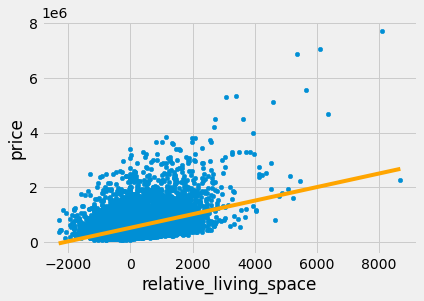

In [54]:
# create a DataFrame with the minimum and maximum values of TV
x_new = pd.DataFrame({'relative_living_space': [df1['relative_living_space'].min(), df1['relative_living_space'].max()]})

# make predictions for those x values and store them
pred = space_model.predict(x_new)

# first, plot the observed data and the least squares line
df1.plot(kind='scatter',x='relative_living_space',y='price')
plt.plot(x_new,pred,color='orange',)
plt.show()

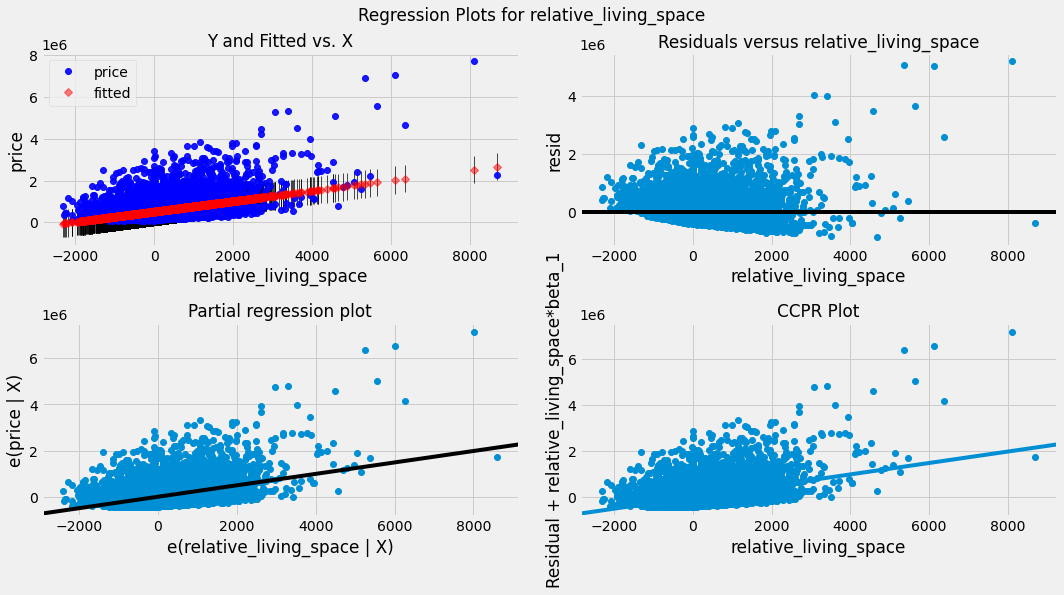

In [70]:
# visualizing error term for variance an heteroscedascticity
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(space_model, "relative_living_space", fig=fig)
plt.show()

<ipython-input-71-4ad4dd444ef0>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


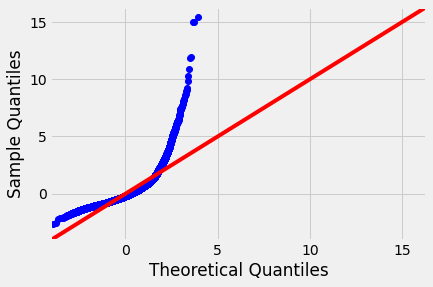

In [71]:
# Code for QQ-plot here
residuals = space_model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

In [53]:
print(grade_model.pvalues)
grade_model.summary()

Intercept    0.0
grade        0.0
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     2834.
Date:                Sun, 06 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:30:43   Log-Likelihood:            -3.0606e+05
No. Observations:               21597   AIC:                         6.121e+05
Df Residuals:                   21595   BIC:                         6.121e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9.961e+05   8877.423    112.201      0.000    9.79e+05    1.01e+06
grade       -6.56e+04   1232.092    -53.239      0.000    -6.8e+04   -6.32e+04
==============================================================================
Omnibus:                    17056.796   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           860549.123
Skew:                           3.395   Prob(JB):                         0.00
Kurtosis:                      33.170   Cond. No.                         27.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

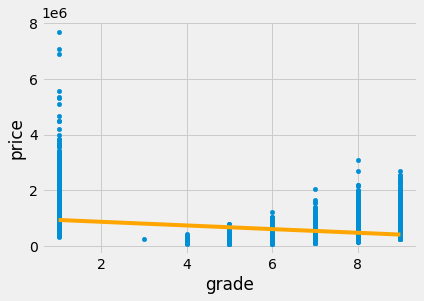

In [60]:
# create a DataFrame with the minimum and maximum values of TV
x_new = pd.DataFrame({'grade': [df1['grade'].min(), df1['grade'].max()]})

# make predictions for those x values and store them
pred = grade_model.predict(x_new)

# first, pgrade the observed data and the least squares line
df1.plot(kind='scatter',x='grade',y='price')
plt.plot(x_new,pred,color='orange')
plt.show()

<ipython-input-72-00bac46f895b>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


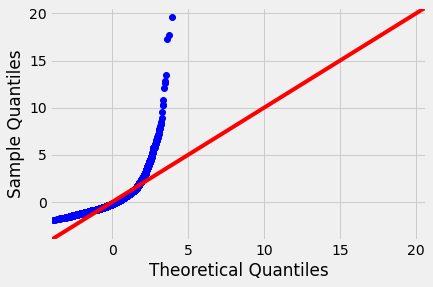

In [72]:
residuals = grade_model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

In [63]:
dfo.columns

Index(['price', 'grade', 'sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms'], dtype='object')

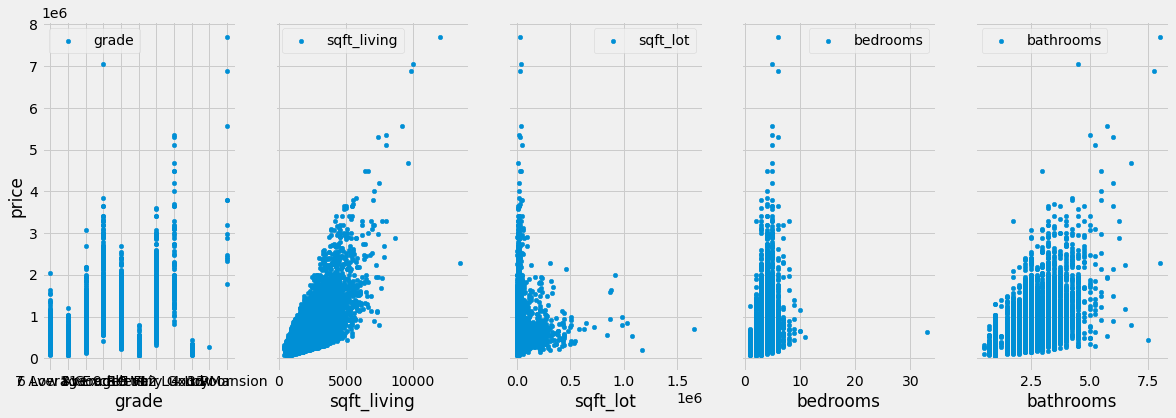

In [65]:
# visualize the relationship between the predictors and the target using scatterplots
fig, axs = plt.subplots(1, 5,sharey=True, figsize=(18, 6))
for idx, channel in enumerate(['grade', 'sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms']):
    dfo.plot(kind='scatter', x=channel, y='price', ax=axs[idx], label=channel)
plt.legend()
plt.show()

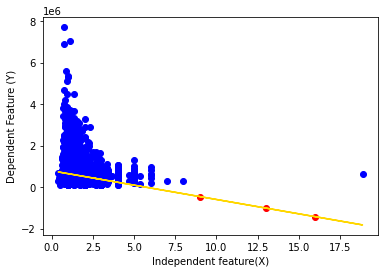

In [11]:
# Does this really mean more bathrooms means more value?
x = df1['bed_bath_ratio']
y = df1['price']
x_new = [9,13,16]

srl.simpregplot(x,y,x_new)

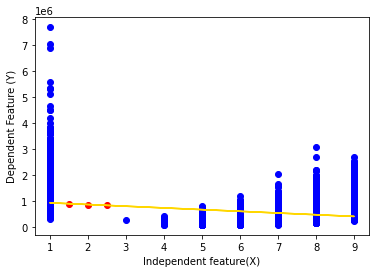

In [7]:
x = df1['grade']
y = df1['price']
x_new = [1.5,2,2.5]
srl.simpregplot(x,y,x_new)

In [8]:
# Why do the most valuable houses have the worst grades?
low_grade_df = df1.loc[df1['grade']<2]
# print(max(low_grade_df['price']))
# print(min(low_grade_df['price']))
low_grade_df.describe()

,price,day_of_year,relative_living_space,relative_lot_size,bed_bath_ratio,grade
count,1.635000e+03,1635.000000,1635.000000,1.635000e+03,1635.000000,1635.0
mean,1.258670e+06,184.829969,656.523547,8.224548e+03,1.292584,1.0
std,7.073721e+05,92.256337,1047.732492,5.289162e+04,0.297684,0.0
min,3.160000e+05,2.000000,-1800.000000,-1.320630e+05,0.500000,1.0
25%,8.127500e+05,114.000000,0.000000,-6.755000e+02,1.111111,1.0
50%,1.040000e+06,177.000000,380.000000,0.000000e+00,1.230769,1.0
75%,1.490000e+06,255.000000,1160.000000,2.558000e+03,1.538462,1.0
max,7.700000e+06,365.000000,8690.000000,1.012368e+06,2.666667,1.0


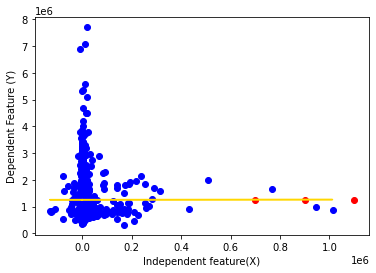

In [9]:
x = low_grade_df['relative_lot_size']
y = low_grade_df['price']
x_new = [700000,900000,1100000]
srl.simpregplot(x,y,x_new)